In [27]:
import os
import sys
import glob
import math
import random
import numpy as np
import argparse
import configparser
from pathlib import Path
from tqdm import trange, tqdm
from datetime import datetime

from scipy import interpolate
from scipy.interpolate.interpnd import _ndim_coords_from_arrays
from scipy.spatial import cKDTree

from astropy import units as u
from astropy import constants
from astropy import constants

from astropy.io import fits
from astropy.io.fits import Header
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Galactic

from pybaselines import Baseline
import matplotlib.pyplot as plt

from gustoL09P.GL09PDataIO import loadL08Data

output_filename = '/Volumes/GUSTO/integrated-G345a-%s.csv' % datetime.today().strftime('%Y-%m-%d')
output_stream = open(output_filename,"a")
directory = '/Volumes/GUSTO/Data/level0.9/G345/'
lineout = "SERIES,LINEFREQ,GLON,GLAT,SCANDIR,TARMS,MIXER,VN150,VN140,VN130,VN120,VN110,VN100,VN090,VN080,VN070,VN060,VN050,VN040,VN030,VN020,VN010,VP000,VP010,VP020,VP030,VP040,VP050,VP060,VP070,VP080,VP090,VP100\n"
output_stream.write(lineout)

velocity_width=10
velocity_bins=np.arange(-150,110,velocity_width)
baseline_size=20

for input_filename in tqdm(os.listdir(directory)):
    ifile = os.path.join(directory,input_filename)
    dsc = int(input_filename.split('_')[2].split('.')[0])
    if dsc <= 27618:
        continue
    spec, data, hdr, hdr1 = loadL08Data(ifile, verbose=False)
    rowFlag = data['ROW_FLAG']
    n_spec, n_pix = spec.shape
    
    # compute velocity                                                           
    npix    = hdr['NPIX']            
    IF_pix  = hdr['CRPIX1']
    IF_val  = hdr['CRVAL1']
    IF_del  = 4.887586
    IF_freq = (np.arange(npix)-IF_pix)*IF_del+IF_val
    VLSR    = hdr['VLSR']        
    
    IF_vlsr0= hdr['IF0']
    line_freq = hdr['LINEFREQ']

    if line_freq < 1900500:
        continue
    
    vlsr    = (IF_vlsr0 - IF_freq)/line_freq*constants.c.value/1.e3 + VLSR # Vlsr in km/s 
    #x_vlsr = ((line_freq/T['freq'][1])-1)*299792
    
    
    
    rms = np.zeros(n_spec)
    basecorrf = np.zeros((n_spec,n_pix))
    #prange = [int(hdr['pgpixst']), int(hdr['pgpixen'])]
    osel = np.argwhere((data['scan_type'] == 'OTF') & (data['ROW_FLAG']==0)).flatten()
    
    if len(osel) <= 0:
        print('WARNING: No OTF spectra available in ',input_filename)
        # logger.warning('No OTF spectra available.')                           
    else:
        spec_OTF = np.squeeze(spec[osel,:])
        data_OTF = np.squeeze(data[osel])
        n_OTF, n_otfpix = spec_OTF.shape
        x=np.arange(n_otfpix)
    
        # Instantiate for ra,dec->l,b transform                                      
        c_ra_dec = SkyCoord(ra=data_OTF['RA']*u.degree, dec=data_OTF['DEC']*u.degree, frame='icrs')
    
        basecorr = np.zeros(spec_OTF.shape)
        rmsotf = np.zeros(n_OTF)
        rf = np.zeros(n_OTF)
    
        # empty arrays to fill                                                        

        c_l_b = c_ra_dec.transform_to(Galactic)    # transform to l,b

        if c_l_b.l.value[0] < 344.0:
            continue
        if c_l_b.l.value[0] > 346.0:
            continue
        
        if c_l_b.b.value[0] < c_l_b.b.value[n_OTF-1]:
            direction='P';
        else:
            direction='N';
        
        #plt.clf()
        #        print('processing data ...')
        # calculate total power                                             
        for i0 in range(n_OTF):
            ii=np.array([])
            for vel_start in velocity_bins:
                # Setup baseline fitting and integrated intensity                             
                # baseline from -50 km/s to +50 km/s                                          
                xlow   = np.argmin(np.abs(vlsr - (vel_start+velocity_width+baseline_size)))
                xhigh  = np.argmin(np.abs(vlsr - (vel_start-baseline_size)))
                # integrated intensity from -30 km/s to +30 km/s                           
                iilow  = np.argmin(np.abs(vlsr - (vel_start+velocity_width))) - xlow
                iihigh = np.argmin(np.abs(vlsr - (vel_start))) - xlow

                base = np.zeros([n_OTF,xhigh-xlow])
                baseline_fitter = Baseline(x_data=x[xlow:xhigh])
                y_flat = np.zeros(xhigh-xlow)

                # Baseline fitting
                #range of velocities?
                spec_to_draw = spec_OTF[i0,xlow:xhigh] - np.median(spec_OTF[i0,xlow:xhigh])
                spec_new = spec_to_draw - base[i0,0:(xhigh-xlow)]
                if spec_new.compressed().shape[0] > 10:
                    base2 = baseline_fitter.aspls(spec_new, 1e5)
                    y_flat = spec_new - base2[0]
                    # Fill integrated intensity and l,b                                    
                    ii = np.append(ii, np.ma.sum(y_flat[iilow:iihigh]))
                    #plt.plot(vlsr[xlow:xhigh],y_flat)
                    #print(line_freq,c_l_b.l.value[i0],c_l_b.b.value[i0],direction,data_OTF['RA'][i0],data_OTF['DEC'][i0],np.ma.sum(y_flat[iilow:iihigh]),sum(spec_OTF.data[i0,prange[0]:prange[1]]),data_OTF['RMS'][i0],data_OTF['MIXER'][i0])
                else:
                    ii = np.append(ii, 0.0)
            lineout = "%d,%9.0f,%9.5f,%9.5f,%s,%9.5f,%d,%9.5f,%9.5f,%9.5f,%9.5f,%9.5f,%9.5f,%9.5f,%9.5f,%9.5f,%9.5f,%9.5f,%9.5f,%9.5f,%9.5f,%9.5f,%9.5f,%9.5f,%9.5f,%9.5f,%9.5f,%9.5f,%9.5f,%9.5f,%9.5f,%9.5f,%9.5f\n" % (dsc,line_freq,c_l_b.l.value[i0],c_l_b.b.value[i0],direction,0.0,data_OTF['MIXER'][i0],ii[0],ii[1],ii[2],ii[3],ii[4],ii[5],ii[6],ii[7],ii[8],ii[9],ii[10],ii[11],ii[12],ii[13],ii[14],ii[15],ii[16],ii[17],ii[18],ii[19],ii[20],ii[21],ii[22],ii[23],ii[24],ii[25])
            output_stream.write(lineout)

output_stream.close()
#plt.ylim(-10, 80)
#plt.vlines(30, -5, 40)
#plt.vlines(-30, -5, 40)

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 500/503 [05:43<00:02,  1.46it/s]


LinAlgError: singular matrix

In [28]:
output_stream.close()
print(xlow,vlsr[xlow],iilow+xlow,vlsr[iilow+xlow],iihigh+xlow,vlsr[iihigh+xlow],xhigh,vlsr[xhigh])

480 -70.35896259881613 505 -89.63327060526886 518 -99.65591076862431 544 -119.70119109533518


In [4]:
import os
import sys
import glob
import math
import random
import numpy as np
import argparse
import configparser
from pathlib import Path
from tqdm import trange, tqdm
from datetime import datetime

from scipy import interpolate
from scipy.interpolate.interpnd import _ndim_coords_from_arrays
from scipy.spatial import cKDTree

from astropy import units as u
from astropy import constants
from astropy import constants

from astropy.io import fits
from astropy.io.fits import Header
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Galactic

from pybaselines import Baseline
import matplotlib.pyplot as plt

from gustoL09P.GL09PDataIO import loadL08Data

velocity_width=10
velocity_bins=np.arange(-150,110,velocity_width)
baseline_size=20

ifile='/Volumes/GUSTO/Data/level0.9/CII_02883_08787_L09.fits'
dsc = int(ifile.split('_')[2].split('.')[0])
spec, data, hdr, hdr1 = loadL08Data(ifile, verbose=False)
rowFlag = data['ROW_FLAG']
n_spec, n_pix = spec.shape
# compute velocity                                                           
npix    = hdr['NPIX']            
IF_pix  = hdr['CRPIX1']
IF_val  = hdr['CRVAL1']
IF_del  = 4.887586
IF_freq = (np.arange(npix)-IF_pix)*IF_del+IF_val
VLSR    = hdr['VLSR']        
    
IF_vlsr0= hdr['IF0']
line_freq = hdr['LINEFREQ']

vlsr    = (IF_vlsr0 - IF_freq)/line_freq*constants.c.value/1.e3 + VLSR # Vlsr in km/s 
    
rms = np.zeros(n_spec)
basecorrf = np.zeros((n_spec,n_pix))
#prange = [int(hdr['pgpixst']), int(hdr['pgpixen'])]
osel = np.argwhere((data['scan_type'] == 'OTF') & (data['ROW_FLAG']==0)).flatten()
    
if len(osel) <= 0:
    print('WARNING: No OTF spectra available in ',ifile)
else:
    spec_OTF = np.squeeze(spec[osel,:])
    data_OTF = np.squeeze(data[osel])
    n_OTF, n_otfpix = spec_OTF.shape
    x=np.arange(n_otfpix)
    
    # Instantiate for ra,dec->l,b transform                                      
    c_ra_dec = SkyCoord(ra=data_OTF['RA']*u.degree, dec=data_OTF['DEC']*u.degree, frame='icrs')
    
    basecorr = np.zeros(spec_OTF.shape)
    rmsotf = np.zeros(n_OTF)
    rf = np.zeros(n_OTF)
    c_l_b = c_ra_dec.transform_to(Galactic)    # transform to l,b

    for i0 in range(n_OTF):
        ii=np.array([])
        for vel_start in velocity_bins:
            # Setup baseline fitting and integrated intensity                             
            # baseline from -50 km/s to +50 km/s                                          
            xlow   = np.argmin(np.abs(vlsr - (vel_start+velocity_width+baseline_size)))
            xhigh  = np.argmin(np.abs(vlsr - (vel_start-baseline_size)))
            # integrated intensity from -30 km/s to +30 km/s                           
            iilow  = np.argmin(np.abs(vlsr - (vel_start+velocity_width))) - xlow
            iihigh = np.argmin(np.abs(vlsr - (vel_start))) - xlow

            base = np.zeros([n_OTF,xhigh-xlow])
            baseline_fitter = Baseline(x_data=x[xlow:xhigh])
            y_flat = np.zeros(xhigh-xlow)

            # Baseline fitting
            #range of velocities?
            spec_to_draw = spec_OTF[i0,xlow:xhigh] - np.median(spec_OTF[i0,xlow:xhigh])
            spec_new = spec_to_draw - base[i0,0:(xhigh-xlow)]
            if spec_new.compressed().shape[0] > 10:
                base2 = baseline_fitter.aspls(spec_new, 1e5)
                y_flat = spec_new - base2[0]
                # Fill integrated intensity and l,b                                    
                ii = np.append(ii, np.ma.sum(y_flat[iilow:iihigh]))
                #plt.plot(vlsr[xlow:xhigh],y_flat)
                #print(line_freq,c_l_b.l.value[i0],c_l_b.b.value[i0],direction,data_OTF['RA'][i0],data_OTF['DEC'][i0],np.ma.sum(y_flat[iilow:iihigh]),sum(spec_OTF.data[i0,prange[0]:prange[1]]),data_OTF['RMS'][i0],data_OTF['MIXER'][i0])
            else:
                ii = np.append(ii, 0.0)


1212
333.46820693157497 -0.9129773272632458


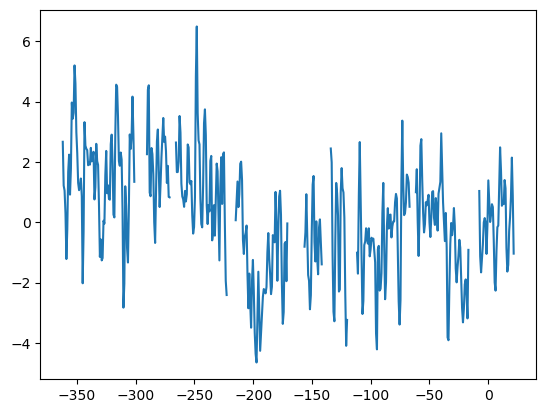

In [10]:
print(n_OTF)
print(c_l_b.l.value[2],c_l_b.b.value[2])
plt.plot(vlsr,spec_OTF[900])

In [165]:
velocity_width=10
velocity_bins=np.arange(-150,50,velocity_width)
baseline_size=20

for vel_start in velocity_bins:
    xlow   = np.argmin(np.abs(vlsr - (vel_start+velocity_width+baseline_size)))
    xhigh  = np.argmin(np.abs(vlsr - (vel_start-baseline_size)))
    # integrated intensity from -30 km/s to +30 km/s                           
    iilow  = np.argmin(np.abs(vlsr - (vel_start+velocity_width))) - xlow
    iihigh = np.argmin(np.abs(vlsr - (vel_start))) - xlow
    print(xlow,vlsr[xlow],iilow+xlow,vlsr[iilow+xlow],iihigh+xlow,vlsr[iihigh+xlow],xhigh,vlsr[xhigh])

295 -120.13768453827882 315 -140.19420811898732 325 -150.22246990934158 345 -170.27899349005008
285 -110.10942274792461 305 -130.16594632863308 315 -140.19420811898732 335 -160.25073169969585
275 -100.08116095757033 295 -120.13768453827882 305 -130.16594632863308 325 -150.22246990934158
265 -90.05289916721611 285 -110.10942274792461 295 -120.13768453827882 315 -140.19420811898732
255 -80.02463737686185 275 -100.08116095757033 285 -110.10942274792461 305 -130.16594632863308
245 -69.99637558650763 265 -90.05289916721611 275 -100.08116095757033 295 -120.13768453827882
235 -59.96811379615336 255 -80.02463737686185 265 -90.05289916721611 285 -110.10942274792461
225 -49.93985200579914 245 -69.99637558650763 255 -80.02463737686185 275 -100.08116095757033
215 -39.911590215444875 235 -59.96811379615336 245 -69.99637558650763 265 -90.05289916721611
205 -29.883328425090628 225 -49.93985200579914 235 -59.96811379615336 255 -80.02463737686185
195 -19.85506663473639 215 -39.911590215444875 225 -49.9

In [162]:
print("%9.5f" % vlsr)

TypeError: only length-1 arrays can be converted to Python scalars

In [41]:
spec_OTF.shape

(413, 1024)

In [47]:
x_vlsr = ((line_freq/T['freq'][1])-1)*299792

(454,)

In [10]:
output_stream.close()

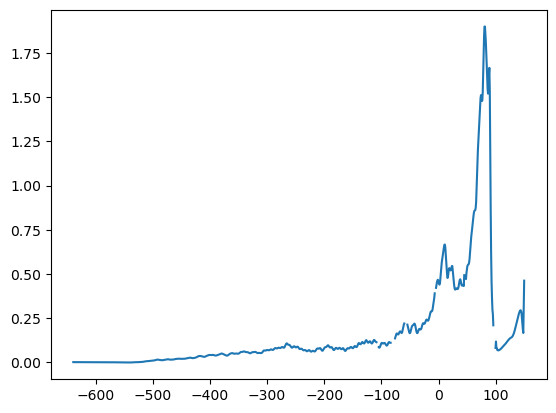

In [92]:
plt.plot(vlsr,spec_OTF[21])

In [59]:
hdr1


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
CALID   =                 8994 / ID of correlator calibration                   
CUNIT1  = 'MHz     '           / Spectral unit                                  
CRPIX1  =                   0. / Index location                                 
CRVAL1  =                   0. / Start of spectra (MHz)                         
CDELT1  =             4.887586 / Channel width (MHz)                            
HKSCANID=                 8996 / nearest H/K measurement                        
TELESCOP= 'GUSTO   '        

In [61]:
hdr1['VELO-LSR']

KeyError: "Keyword 'VELO-LSR' not found."

In [62]:
hdr['IF0']

930.0

In [63]:
hdr['LINEFREQ']

1900537.0

In [64]:
hdr['NPIX']

1024

In [145]:
import datetime
output_filename = '/Volumes/GUSTO/integrated-%s.csv' % datetime.datetime.today().strftime('%Y-%m-%d')


In [146]:
output_filename

'/Volumes/GUSTO/integrated-2024-12-31.csv'

In [147]:
dsc = int(input_filename.split('_')[1].split('.')[0])

In [148]:
dsc

9320

In [168]:
output_stream.close()